In [33]:
import numpy as np

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import seml.database as db_utils
from pathlib import Path

import torch

from itertools import product

from statsmodels.stats.proportion import proportion_confint

import pandas as pd

import os

import sys
sys.path.append('..')
from utils import load_results, plot_results_dict

#%matplotlib inline

In [34]:
collection = 'equivariance_force_fields_cert'


jk_config = {
    'username': 'your-username',
    'password': 'your-password',
    'host': 'your-host-address',
    'port': 27017,
    'db_name': 'your-dbname'
}

col = db_utils.get_collection(collection, mongodb_config=jk_config)

In [35]:
def get_experiments(col, restrictions={}):
    
    restrictions['status'] = 'COMPLETED'

    if col.count_documents(restrictions) == 0:
        raise ValueError('No matches!')

    exps = col.find(restrictions, {'config':1, 'result': 1, '_id': 1})
    
    return exps

In [36]:
def get_certificates(raw_results_file):
    raw_results = torch.load(raw_results_file)

    budgets = raw_results['budgets'][0]
    assert torch.all(budgets == torch.stack(raw_results['budgets'], dim=0))

    average_error = np.mean(raw_results['pred_errors'])
    n_abstains = np.sum(raw_results['abstains'])
    max_rad = raw_results['max_rad']
    n_molecules = len(raw_results['certified_output_distances'])

    average_certified_output_distances = None

    for abstain, dists in zip(raw_results['abstains'], raw_results['certified_output_distances']):
        if abstain:
            continue
        else:
            if average_certified_output_distances is None:
                average_certified_output_distances = dists / (n_molecules - n_abstains)
            else:
                average_certified_output_distances += dists / (n_molecules - n_abstains)

    return {
        'average_error': average_error,
        'n_abstains': n_abstains,
        'max_rad': max_rad,
        'budgets': budgets.numpy(),
        'average_certified_output_distances': average_certified_output_distances.numpy()
    }

In [37]:
def generate_exp_result_dict(exp):

    result_dict = {}

    result_dict['dataset'] = exp['config']['dataset']
    result_dict['seed'] = exp['config']['train_loading']['restrictions']['model_seed']

    result_dict['target'] = exp['config']['target']
    result_dict['std'] = exp['config']['smoothing_params']['std']
    result_dict['delta'] = exp['config']['smoothing_params']['delta']

    result_dict['raw_results_file'] = exp['result']['save_file']

    cert_dict = get_certificates(result_dict['raw_results_file'])

    result_dict.update(cert_dict)

    return result_dict

In [38]:
# Use commented out code if you want to use your own data
#experiments = get_experiments(col, restrictions={'config.n_molecules': 1000, 'config.model_name': 'dimenet++'})
#results = load_results(
#            generate_exp_result_dict,
#            experiments,
#            results_file='./raw_data',
#            overwrite=True
#            )

results = load_results(
            generate_exp_result_dict,
            None,
            results_file='./raw_data',
            overwrite=False
            )

In [39]:
results

,dataset,seed,target,std,delta,raw_results_file,average_error,n_abstains,max_rad,budgets,average_certified_output_distances
0,MD17,0,aspirin,0.0001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.743688,0,0.000201,"[0.0, 2.0139126e-07, 4.0278252e-07, 6.041738e-...","[0.0, 0.5521176, 0.5523162, 0.5525132, 0.55271..."
1,MD17,0,salicylic acid,0.0001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.492034,0,0.000201,"[0.0, 2.0139126e-07, 4.0278252e-07, 6.041738e-...","[0.0, 0.5491222, 0.54933935, 0.5495603, 0.5497..."
2,MD17,1,aspirin,0.0001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.708687,0,0.000201,"[0.0, 2.0139126e-07, 4.0278252e-07, 6.041738e-...","[0.0, 0.5516415, 0.5518389, 0.55203277, 0.5522..."
3,MD17,0,ethanol,0.0001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.363281,0,0.000201,"[0.0, 2.0139126e-07, 4.0278252e-07, 6.041738e-...","[0.0, 0.39879346, 0.39901617, 0.3992412, 0.399..."
4,MD17,0,malonaldehyde,0.0001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.599046,0,0.000201,"[0.0, 2.0139126e-07, 4.0278252e-07, 6.041738e-...","[0.0, 0.4937712, 0.4940865, 0.49439985, 0.4947..."
...,...,...,...,...,...,...,...,...,...,...,...
130,MD17,4,salicylic acid,0.0010,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.862154,0,0.002012,"[0.0, 2.0139125e-06, 4.027825e-06, 6.041738e-0...","[0.0, 5.494568, 5.496737, 5.49894, 5.5011435, ..."
131,MD17,2,aspirin,0.0010,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,1.050655,0,0.002012,"[0.0, 2.0139125e-06, 4.027825e-06, 6.041738e-0...","[0.0, 5.518387, 5.5203514, 5.522325, 5.5243053..."
132,MD17,3,uracil,0.0010,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.741296,0,0.002012,"[0.0, 2.0139125e-06, 4.027825e-06, 6.041738e-0...","[0.0, 5.9578176, 5.9607296, 5.9636145, 5.96656..."
133,MD17,2,toluene,0.0010,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.635094,0,0.002012,"[0.0, 2.0139125e-06, 4.027825e-06, 6.041738e-0...","[0.0, 4.8640847, 4.866079, 4.8680687, 4.870043..."


In [40]:
res = results.loc[results['std'] == 0.00001]
res

,dataset,seed,target,std,delta,raw_results_file,average_error,n_abstains,max_rad,budgets,average_certified_output_distances
63,MD17,0,aspirin,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.738639,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.05521437, 0.055233758, 0.055253476, 0...."
64,MD17,0,ethanol,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.361214,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.039879676, 0.039902505, 0.03992484, 0...."
65,MD17,0,toluene,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.245927,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.048634514, 0.048654288, 0.04867495, 0...."
66,MD17,0,uracil,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.411972,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.059564296, 0.059593774, 0.05962313, 0...."
67,MD17,0,benzene,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.389724,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.052827105, 0.052851204, 0.052875802, 0..."
68,MD17,0,salicylic acid,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.485800,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.054916542, 0.054938566, 0.054960385, 0..."
69,MD17,0,malonaldehyde,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.597792,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.04937805, 0.04940933, 0.049441192, 0.0..."
70,MD17,0,napthalene,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.212099,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.0538402, 0.053859603, 0.053878885, 0.0..."
71,MD17,1,uracil,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.360647,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.05959486, 0.05962385, 0.05965295, 0.05..."
72,MD17,3,aspirin,0.00001,0.05,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.701250,0,0.00002,"[0.0, 2.0139126e-08, 4.0278252e-08, 6.041738e-...","[0.0, 0.055171844, 0.05519185, 0.055211615, 0...."


In [41]:
min_factor = 1000000000000000000
max_factor = -10000000000

for i in range(len(res)):
    row = res.iloc[i]
    err = row['average_error']
    min_change, max_change = row['average_certified_output_distances'][[1, -2]]

    min_factor = min(min_factor, err / max_change)
    max_factor = max(max_factor, err / min_change)

print(min_factor)
print(max_factor)

1.9306026373413991
13.377661798624228


In [42]:
results.loc[results['std'] == 0.00001]['average_error'].min()

0.1860638640075922

In [43]:
results.loc[results['std'] == 0.00001]['average_error'].max()

0.7386391887813807

In [44]:
def prepare_plot_dict(res, subsampling_factor=10):
    plot_dict = {}

    print(f'Preparing {len(res)} results.')

    for i in range(len(res)):
        row = res.iloc[i]

        if row['target'].capitalize() not in plot_dict:
            plot_dict[row['target'].capitalize()] = {
                'budgets': row['budgets'][:-1][::subsampling_factor],
                'cert_metrics': [row['average_certified_output_distances'][:-1]]
            }
        
        else:
            plot_dict[row['target'].capitalize()]['cert_metrics'].append(row['average_certified_output_distances'][:-1])

    for k in plot_dict.keys():
        plot_dict[k]['errors'] = np.std(plot_dict[k]['cert_metrics'], axis=0)[::10]
        plot_dict[k]['cert_metrics'] = np.mean(plot_dict[k]['cert_metrics'], axis=0)[::10]
        

    return plot_dict

Preparing 40 results.
Max error for Aspirin is 5.0196493248222396e-05
Max error for Uracil is 3.197083788109012e-05
Max error for Ethanol is 1.6707735994714312e-05
Max error for Benzene is 0.00022445218928623945
Max error for Napthalene is 6.758053586963797e-06
Max error for Toluene is 1.5108006664377172e-05
Max error for Salicylic acid is 3.327085141791031e-05
Max error for Malonaldehyde is 2.109857086907141e-05


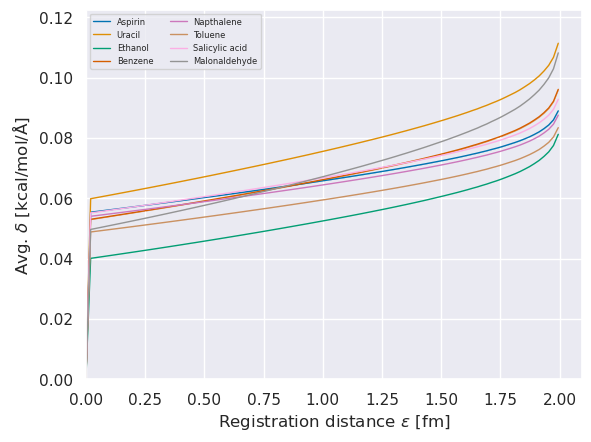

In [45]:
res = results.loc[results['std'] == 0.00001]
plot_dict_00001 = prepare_plot_dict(res)

sns.set_theme()
plot_results_dict(plot_dict_00001, 'Registration distance $\epsilon$ [fm]', 'Avg. $\delta$ [kcal/mol/Å] ', legend_params={'ncols': 2, 'fontsize': 6}, clip_on=True, zorder=None, budget_scaling=10**5,
                    keys=['Aspirin', 'Uracil', 'Ethanol', 'Benzene', 'Napthalene', 'Toluene', 'Salicylic acid', 'Malonaldehyde'])

Preparing 40 results.
Max error for Aspirin is 0.0004654684744309634
Max error for Uracil is 0.00025410516536794603
Max error for Ethanol is 0.00018223254301119596
Max error for Benzene is 0.002164204604923725
Max error for Napthalene is 7.285046740435064e-05
Max error for Toluene is 0.00015276588965207338
Max error for Salicylic acid is 0.00036943238228559494
Max error for Malonaldehyde is 0.0002111017529387027


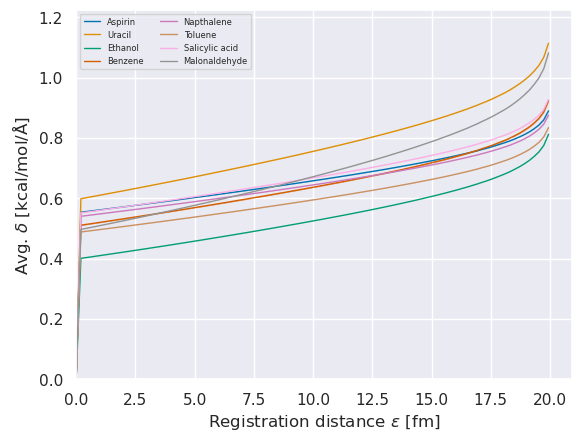

In [46]:
res = results.loc[results['std'] == 0.0001]
plot_dict_0001 = prepare_plot_dict(res)

sns.set_theme()
plot_results_dict(plot_dict_0001, 'Registration distance $\epsilon$ [fm]', 'Avg. $\delta$ [kcal/mol/Å] ', legend_params={'ncols': 2, 'fontsize': 6}, clip_on=True, zorder=None, budget_scaling=10**5,
                    keys=['Aspirin', 'Uracil', 'Ethanol', 'Benzene', 'Napthalene', 'Toluene', 'Salicylic acid', 'Malonaldehyde'])


Preparing 40 results.
Max error for Aspirin is 0.004837946500629187
Max error for Uracil is 0.002350573893636465
Max error for Ethanol is 0.0015473408857360482
Max error for Benzene is 0.021335219964385033
Max error for Napthalene is 0.0006991928676143289
Max error for Toluene is 0.0014759121695533395
Max error for Salicylic acid is 0.003364488948136568
Max error for Malonaldehyde is 0.002329633105546236


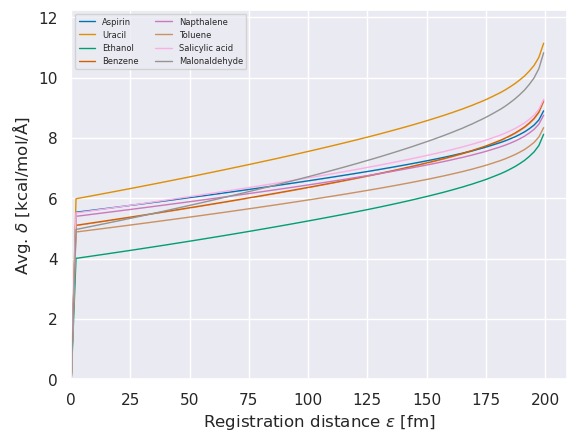

In [47]:
res = results.loc[results['std'] == 0.001]
plot_dict_001 = prepare_plot_dict(res)

sns.set_theme()
plot_results_dict(plot_dict_001, 'Registration distance $\epsilon$ [fm]', 'Avg. $\delta$ [kcal/mol/Å] ', legend_params={'ncols': 2, 'fontsize': 6}, clip_on=True, zorder=None, budget_scaling=10**5,
                    keys=['Aspirin', 'Uracil', 'Ethanol', 'Benzene', 'Napthalene', 'Toluene', 'Salicylic acid', 'Malonaldehyde'])

In [48]:
list(plot_dict_00001.keys())

['Aspirin',
 'Ethanol',
 'Toluene',
 'Uracil',
 'Benzene',
 'Salicylic acid',
 'Malonaldehyde',
 'Napthalene']